In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nakulchamariya","key":"7e36f0cb10fd0e99a608c08cc5782549"}'}

In [2]:
!pip install kaggle

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download mrmorj/hate-speech-and-offensive-language-dataset

  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 39.2MB/s]


In [6]:
!unzip /content/hate-speech-and-offensive-language-dataset.zip
!rm -rf /content/hate-speech-and-offensive-language-dataset.zip

Archive:  /content/hate-speech-and-offensive-language-dataset.zip
  inflating: labeled_data.csv        


In [7]:
import pandas as pd
df = pd.read_csv('/content/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
df.shape

(24783, 7)

In [13]:
df['class'] = df['class'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})
df['class'].value_counts()

offensive_language    19190
neither                4163
hate_speech            1430
Name: class, dtype: int64

In [14]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [15]:
df = df.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',])
df.head()

,class,tweet
0,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,offensive_language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,offensive_language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,offensive_language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,offensive_language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


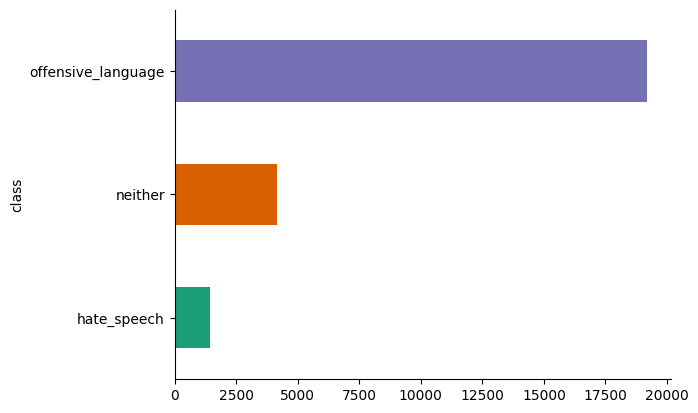

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [18]:
hate_speech_df = df[df['class'] == 'hate_speech'].head(500)
offensive_language_df = df[df['class'] == 'offensive_language'].head(500)
neither_df = df[df['class'] == 'neither'].head(500)

df = pd.concat([hate_speech_df, offensive_language_df, neither_df], ignore_index=True)
df.shape

(1500, 2)

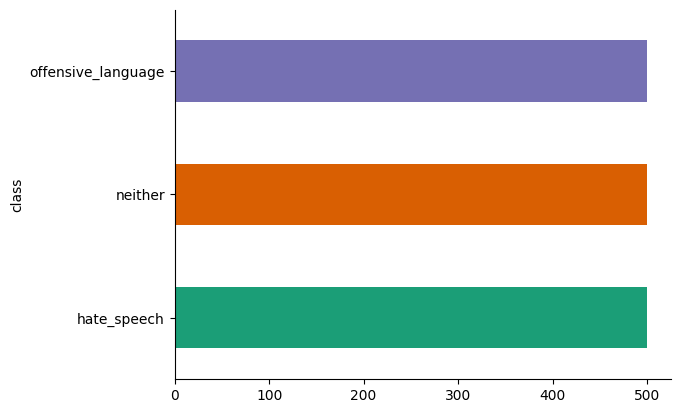

In [19]:
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
df.head()

,class,tweet
0,hate_speech,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
1,hate_speech,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
2,hate_speech,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
3,hate_speech,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
4,hate_speech,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [47]:
X = df['tweet']
y = df['class']

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, stratify=y,test_size=0.25, random_state=101)

In [49]:
X_train.shape,y_train.shape

((1125,), (1125,))

In [50]:
X_test.shape,y_test.shape

((375,), (375,))

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [53]:
X_train.shape,y_train.shape

((1125, 4831), (1125,))

In [54]:
X_test.shape,y_test.shape

((375, 4831), (375,))

In [37]:
!pip install scikit-plot

In [56]:
label = y_test.unique().tolist()
label

['hate_speech', 'offensive_language', 'neither']

In [57]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, log_loss, classification_report
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, X_train, y_train, X_test, y_test, label, include_log_loss=True):
    print(f'Results for {model.__class__.__name__}:\n')

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f'Training time (sec) = {train_time}')

    y_pred_train = model.predict(X_train)

    start_time = time.time()
    y_pred_test = model.predict(X_test)
    test_time = time.time() - start_time
    print(f'Prediction time (sec) = {test_time}')

    y_pred_prob_train = model.predict_proba(X_train) if hasattr(model, 'predict_proba') else None
    y_pred_prob_test = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    confusion_mat = confusion_matrix(y_test, y_pred_test)
    misclassified = np.sum(y_pred_test != y_test.values.ravel())
    acc_train = balanced_accuracy_score(y_train, y_pred_train)
    acc_test = balanced_accuracy_score(y_test, y_pred_test)

    loss_train, loss_test = None, None
    if include_log_loss and y_pred_prob_test is not None:
        loss_train = log_loss(y_train, y_pred_prob_train)
        loss_test = log_loss(y_test, y_pred_prob_test)

    print(f'\nTraining score = {acc_train}')
    print(f'Testing score = {acc_test}\n')

    for i, class_label in enumerate(label):
        err = np.sum(confusion_mat[i]) - confusion_mat[i][i]
        print(f'No of misclassified for class {class_label} (test data) = {err}')

    print(f'Total no of misclassified points (test data) = {misclassified}')
    print(f'Total % of misclassified points (test data) = {misclassified / len(y_test)}\n')

    if loss_train is not None and loss_test is not None:
        print(f'Training log_loss = {loss_train}')
        print(f'Testing log_loss = {loss_test}\n')

    print('Confusion matrix:')
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_test)
    plt.show()

    print('Classification report:\n')
    print(classification_report(y_test, y_pred_test))
    print('**************************************************************************')

    return [acc_train, acc_test, misclassified, misclassified / len(y_test), loss_train, loss_test, train_time, test_time]

Results for LogisticRegression:

Training time (sec) = 2.2511510848999023
Prediction time (sec) = 0.0005125999450683594

Training score = 0.9671111111111111
Testing score = 0.8080000000000002

No of misclassified for class hate_speech (test data) = 34
No of misclassified for class offensive_language (test data) = 13
No of misclassified for class neither (test data) = 25
Total no of misclassified points (test data) = 72
Total % of misclassified points (test data) = 0.192

Training log_loss = 0.45987738579217796
Testing log_loss = 0.6478986620331953

Confusion matrix:


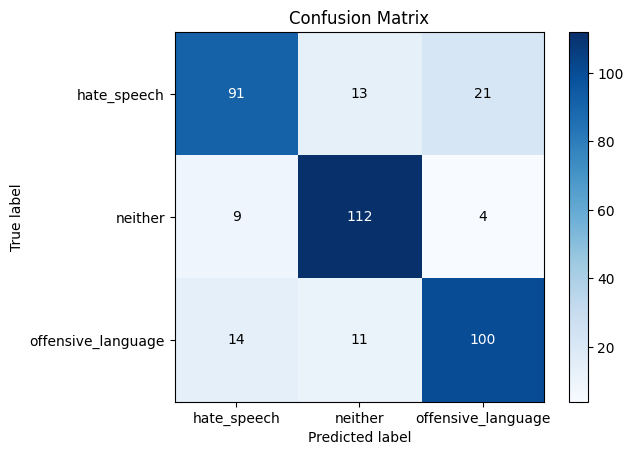

Classification report:

                    precision    recall  f1-score   support

       hate_speech       0.80      0.73      0.76       125
           neither       0.82      0.90      0.86       125
offensive_language       0.80      0.80      0.80       125

          accuracy                           0.81       375
         macro avg       0.81      0.81      0.81       375
      weighted avg       0.81      0.81      0.81       375

**************************************************************************


In [58]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', n_jobs=-1)
LR_results = evaluate_model(lr, X_train, y_train, X_test, y_test, label)

Results for LinearSVC:

Training time (sec) = 0.031438589096069336
Prediction time (sec) = 0.0003123283386230469

Training score = 1.0
Testing score = 0.7973333333333334

No of misclassified for class hate_speech (test data) = 34
No of misclassified for class offensive_language (test data) = 15
No of misclassified for class neither (test data) = 27
Total no of misclassified points (test data) = 76
Total % of misclassified points (test data) = 0.20266666666666666

Confusion matrix:


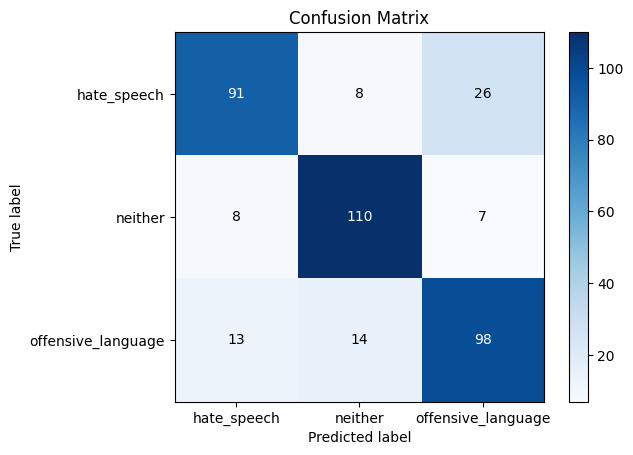

Classification report:

                    precision    recall  f1-score   support

       hate_speech       0.81      0.73      0.77       125
           neither       0.83      0.88      0.86       125
offensive_language       0.75      0.78      0.77       125

          accuracy                           0.80       375
         macro avg       0.80      0.80      0.80       375
      weighted avg       0.80      0.80      0.80       375

**************************************************************************


In [59]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(class_weight='balanced')
LSVC_results = evaluate_model(lsvc, X_train, y_train, X_test, y_test, label)

Results for DecisionTreeClassifier:

Training time (sec) = 0.12332868576049805
Prediction time (sec) = 0.0009396076202392578

Training score = 1.0
Testing score = 0.7120000000000001

No of misclassified for class hate_speech (test data) = 51
No of misclassified for class offensive_language (test data) = 21
No of misclassified for class neither (test data) = 36
Total no of misclassified points (test data) = 108
Total % of misclassified points (test data) = 0.288

Training log_loss = 4.440892098500627e-16
Testing log_loss = 10.38057217606574

Confusion matrix:


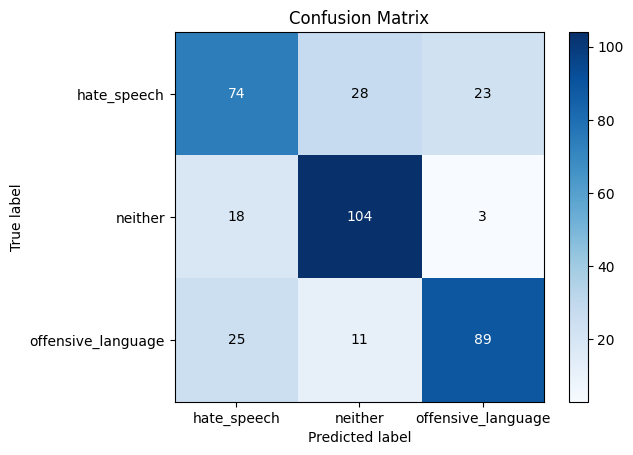

Classification report:

                    precision    recall  f1-score   support

       hate_speech       0.63      0.59      0.61       125
           neither       0.73      0.83      0.78       125
offensive_language       0.77      0.71      0.74       125

          accuracy                           0.71       375
         macro avg       0.71      0.71      0.71       375
      weighted avg       0.71      0.71      0.71       375

**************************************************************************


In [60]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(class_weight='balanced')
DTC_results = evaluate_model(dtc, X_train, y_train, X_test, y_test, label)

Results for ExtraTreesClassifier:

Training time (sec) = 1.5152525901794434
Prediction time (sec) = 0.03355693817138672

Training score = 1.0
Testing score = 0.8053333333333333

No of misclassified for class hate_speech (test data) = 35
No of misclassified for class offensive_language (test data) = 15
No of misclassified for class neither (test data) = 23
Total no of misclassified points (test data) = 73
Total % of misclassified points (test data) = 0.19466666666666665

Training log_loss = 4.440892098500627e-16
Testing log_loss = 0.6107257425816087

Confusion matrix:


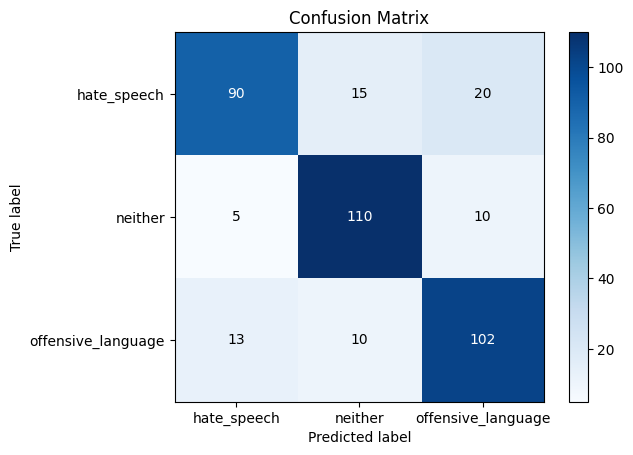

Classification report:

                    precision    recall  f1-score   support

       hate_speech       0.83      0.72      0.77       125
           neither       0.81      0.88      0.85       125
offensive_language       0.77      0.82      0.79       125

          accuracy                           0.81       375
         macro avg       0.81      0.81      0.80       375
      weighted avg       0.81      0.81      0.80       375

**************************************************************************


In [61]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(class_weight='balanced')
ETC_results = evaluate_model(etc, X_train, y_train, X_test, y_test, label)

Results for RandomForestClassifier:

Training time (sec) = 1.0640881061553955
Prediction time (sec) = 0.03083038330078125

Training score = 1.0
Testing score = 0.7706666666666667

No of misclassified for class hate_speech (test data) = 40
No of misclassified for class offensive_language (test data) = 19
No of misclassified for class neither (test data) = 27
Total no of misclassified points (test data) = 86
Total % of misclassified points (test data) = 0.22933333333333333

Training log_loss = 0.16198082888625154
Testing log_loss = 0.641716384983723

Confusion matrix:


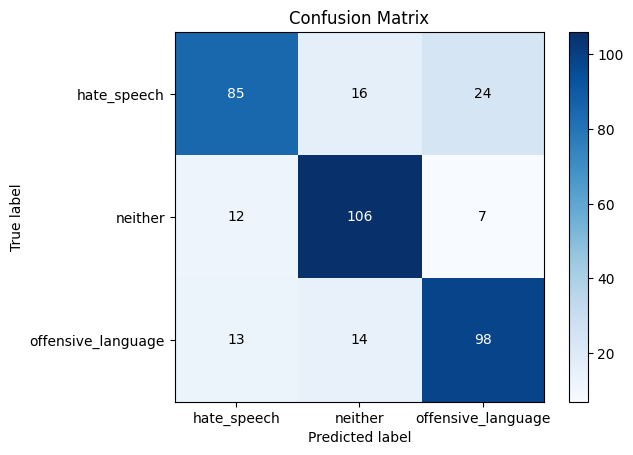

Classification report:

                    precision    recall  f1-score   support

       hate_speech       0.77      0.68      0.72       125
           neither       0.78      0.85      0.81       125
offensive_language       0.76      0.78      0.77       125

          accuracy                           0.77       375
         macro avg       0.77      0.77      0.77       375
      weighted avg       0.77      0.77      0.77       375

**************************************************************************


In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight='balanced')
RFC_results = evaluate_model(rfc, X_train, y_train, X_test, y_test, label)

In [63]:
s1=[LR_results,LSVC_results,DTC_results,ETC_results,RFC_results]
s2=['LR','LSVC','DTC','ETC','RFC']
col=['Train score','Test score','Missclassified-point','% missclasification','Train log-loss','Test log-loss','Training time','Prediction time']
result=dict.fromkeys(s2,None)

for i in range(len(s1)):
    result[s2[i]] = s1[i]

temp = pd.DataFrame.from_dict(result, orient='index',columns=col).reset_index()
result = temp.rename(columns={'index':'Classifiers'})
result

,Classifiers,Train score,Test score,Missclassified-point,% missclasification,Train log-loss,Test log-loss,Training time,Prediction time
0,LR,0.967111,0.808000,72,0.192000,4.598774e-01,0.647899,2.251151,0.000513
1,LSVC,1.000000,0.797333,76,0.202667,NaN,NaN,0.031439,0.000312
2,DTC,1.000000,0.712000,108,0.288000,4.440892e-16,10.380572,0.123329,0.000940
3,ETC,1.000000,0.805333,73,0.194667,4.440892e-16,0.610726,1.515253,0.033557
4,RFC,1.000000,0.770667,86,0.229333,1.619808e-01,0.641716,1.064088,0.030830


In [64]:
vectorizer

TfidfVectorizer()

In [65]:
lr

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [66]:
from sklearn.pipeline import make_pipeline
import joblib
pipeline = make_pipeline(vectorizer, lr)
joblib.dump(pipeline, 'lr_pipeline.joblib')

['lr_pipeline.joblib']

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
!mv "/content/lr_pipeline.joblib" "/content/drive/MyDrive/projects/insta-reel/."